# Pareto-NBD model

Comparison with lifetimes



#### References:
----------
David C. Schmittlein, Donald G. Morrison and Richard Colombo
Management Science,Vol. 33, No. 1 (Jan., 1987), pp. 1-24
"Counting Your Customers: Who Are They and What Will They Do Next,"
    
Fader, Peter & G. S. Hardie, Bruce (2005).
["A Note on Deriving the Pareto/NBD Model and Related Expressions."](http://brucehardie.com/notes/009/pareto_nbd_derivations_2005-11-05.pdf)

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import numpy as np
import warnings

In [2]:
from pymc_marketing.clv.models.pareto_nbd import ParetoNBDModel
from pymc_marketing.clv.distributions import ParetoNBD

In [3]:
# Extra dependency for this notebook
from lifetimes.datasets import load_cdnow_summary
from lifetimes import ParetoNBDFitter

## Load data

In [4]:
df = load_cdnow_summary(index_col=[0])
df.head()

,frequency,recency,T
ID,,,
1,2,30.43,38.86
2,1,1.71,38.86
3,0,0.00,38.86
4,0,0.00,38.86
5,0,0.00,38.86


In [5]:
df.shape

(2357, 3)

In [6]:
x = df["frequency"].values[:]
t_x = df["recency"].values[:]
T = df["T"].values[:]

## Lifetimes implementation

In [7]:
lft = ParetoNBDFitter().fit(x, t_x, T)
lft

<lifetimes.ParetoNBDFitter: fitted with 2357 subjects, alpha: 10.58, beta: 11.67, r: 0.55, s: 0.61>

In [8]:
fit = dict(lft.params_)
fit

{'r': 0.5532781427292868,
 'alpha': 10.577742892540826,
 's': 0.6062326241349367,
 'beta': 11.668551650304016}

In [9]:
ParetoNBDFitter._conditional_log_likelihood(list(fit.values()), x, t_x, T).sum()

-9594.973929850967

## PyMC-Marketing Implementation

Weibull default priors. For an interactive PDF go here:
https://homepage.divms.uiowa.edu/~mbognar/applets/weibull.html

<Axes: ylabel='Density'>

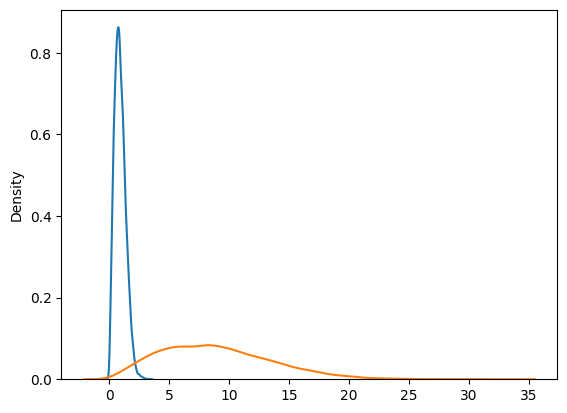

In [10]:
shape_prior = pm.draw(pm.Weibull.dist(alpha=2,beta=1, size=10_000))
scale_prior = pm.draw(pm.Weibull.dist(alpha=2,beta=10, size=10_000))

sns.kdeplot(shape_prior)
sns.kdeplot(scale_prior)

In [11]:
with pm.Model() as m1:
    r = pm.Weibull("r",alpha=2, beta=1)
    alpha = pm.Weibull("alpha", alpha=2, beta=10)
    s = pm.Weibull("s",alpha=2, beta=1)
    beta = pm.Weibull("beta", alpha=2, beta=10)
    llike = ParetoNBD("llike", r=r, alpha=alpha, s=s, beta=beta, T=T, observed=np.stack((t_x, x), axis=1))

In [12]:
pm.logp(llike, np.stack((t_x, x), axis=1)).sum().eval(dict(zip((r, alpha, s, beta), fit.values())))

/home/ricardo/Documents/Projects/pytensor/pytensor/tensor/rewriting/elemwise.py:689: UserWarning: Optimization Warning: The Op hyp2f1 does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(


array(-9594.97392985)

In [13]:
with m1:
    with warnings.catch_warnings():
        warnings.filterwarnings(
            action='ignore',
            category=UserWarning,
            message='Optimization warning: The Op hyp2f1 does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.'
        )   
        idata = pm.sample(init="jitter+adapt_diag_grad")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag_grad...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [r, alpha, s, beta]


/home/ricardo/Documents/Projects/pytensor/pytensor/compile/function/types.py:970: RuntimeWarning: Until condition in ScalarLoop hyp2f1_grad not reached!
  self.vm()
/home/ricardo/Documents/Projects/pytensor/pytensor/compile/function/types.py:970: RuntimeWarning: Until condition in ScalarLoop hyp2f1_grad not reached!
  self.vm()
/home/ricardo/Documents/Projects/pytensor/pytensor/compile/function/types.py:970: RuntimeWarning: Until condition in ScalarLoop hyp2f1_grad not reached!
  self.vm()
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 602 seconds.


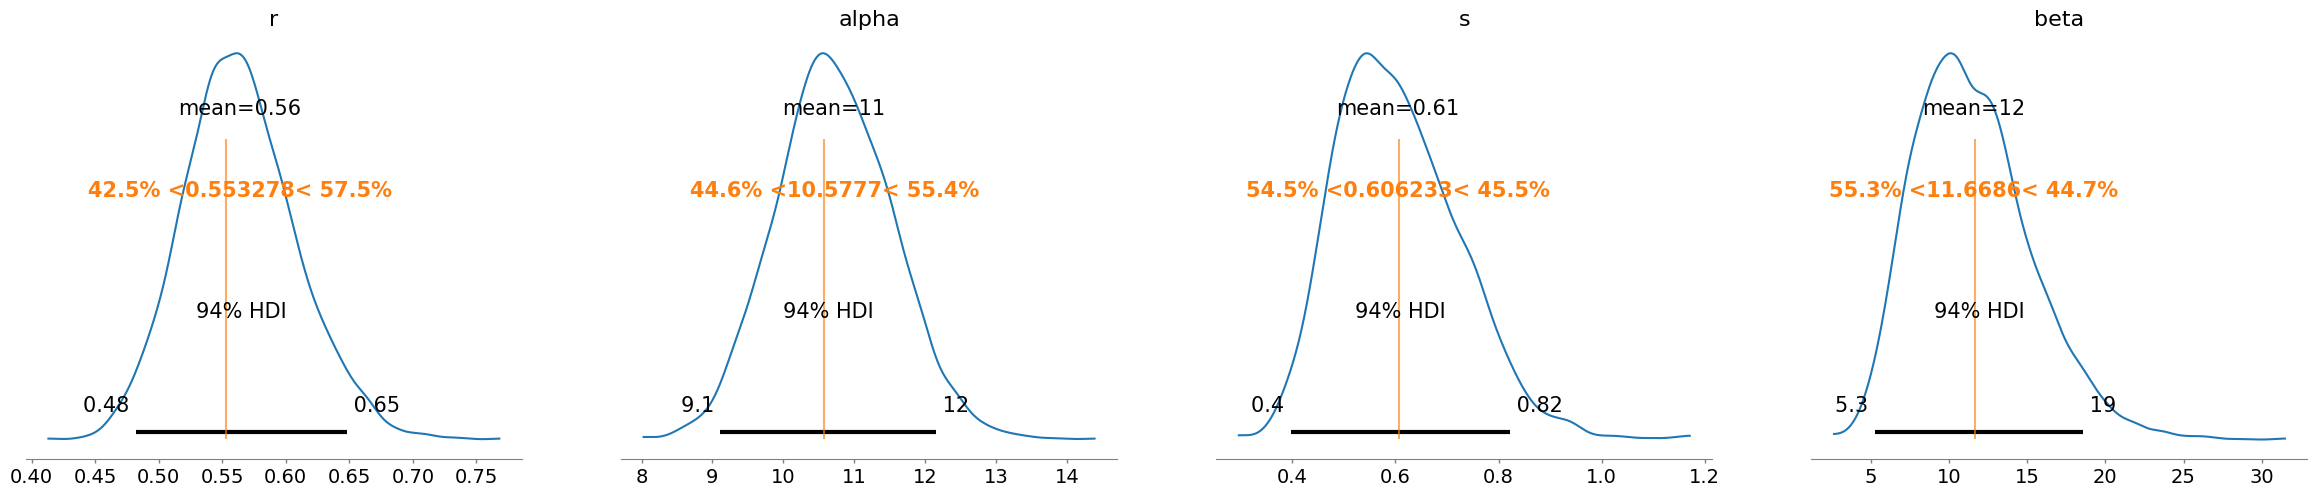

In [14]:
az.plot_posterior(idata, ref_val=list(fit.values()));

In [15]:
pnbd = ParetoNBDModel(df.index,x,t_x,T)

with warnings.catch_warnings():
    warnings.filterwarnings(
        action='ignore',
        category=UserWarning,
        message='Optimization warning: The Op hyp2f1 does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.'
    )      

    pnbd.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [r, alpha, s, beta]


/home/ricardo/Documents/Projects/pytensor/pytensor/compile/function/types.py:970: RuntimeWarning: Until condition in ScalarLoop hyp2f1_grad not reached!
  self.vm()
/home/ricardo/Documents/Projects/pytensor/pytensor/compile/function/types.py:970: RuntimeWarning: Until condition in ScalarLoop hyp2f1_grad not reached!
  self.vm()
/home/ricardo/Documents/Projects/pytensor/pytensor/compile/function/types.py:970: RuntimeWarning: Until condition in ScalarLoop hyp2f1_grad not reached!
  self.vm()
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 277 seconds.


In [16]:
pnbd.fit_summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
r,0.579,0.035,0.515,0.645,0.001,0.001,2411.0,2441.0,1.0
alpha,10.626,0.566,9.576,11.688,0.012,0.008,2366.0,2401.0,1.0
s,0.595,0.050,0.509,0.692,0.001,0.001,2187.0,2230.0,1.0
beta,10.119,0.921,8.305,11.656,0.021,0.015,2161.0,1879.0,1.0


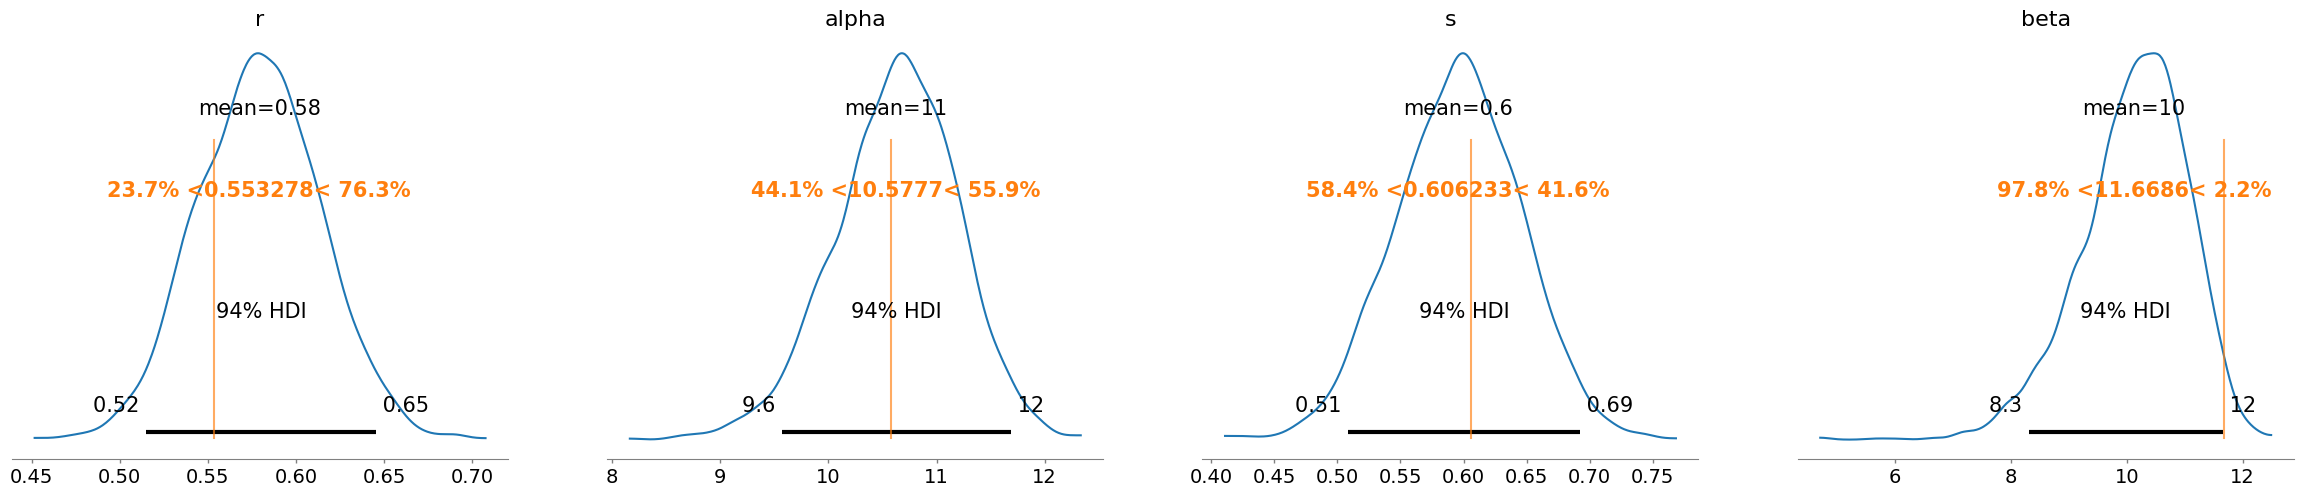

In [17]:
az.plot_posterior(pnbd.fit_result, ref_val=list(fit.values()));

## Testing MAP

In [21]:
fit

{'r': 0.5532781427292868,
 'alpha': 10.577742892540826,
 's': 0.6062326241349367,
 'beta': 11.668551650304016}

In [22]:
with m1:
    with warnings.catch_warnings():
        warnings.filterwarnings(
            action='ignore',
            category=UserWarning,
            message='Optimization warning: The Op hyp2f1 does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.'
        )   
        
        res = pm.find_MAP()

In [23]:
{k: res[k] for k in fit}

{'r': array(0.55961892),
 'alpha': array(10.59116019),
 's': array(0.55028984),
 'beta': array(9.75557741)}